In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from scipy.optimize import curve_fit
from math import floor, log10
#df = pd.read_csv('SimplestClean15sigma/131125_darkrate_1750_10000_1_off_clean.csv')

In [44]:
"""
Cleaned CSV has columns:

            'baseline': mean_b_array,
            'sd_baseline': sigma_b_array,
            'amplitude': all_amplitudes,
            'peak_time': all_peak_times,
            'FWHM': all_FWHM,
            't1_of_FWHM': all_t1,
            't2_of_FWHM': all_t2,
            'time_above_15sigma': all_time_above_15thresh,
            'first_15sigma_crossing': all_first_15crossing,
            'second_15sigma_crossing': all_second_15crossing,
            'time_above_10sigma': all_time_above_10thresh,
            'first_10sigma_crossing': all_first_10crossing,
            'second_10sigma_crossing': all_second_10crossing,
            'time_above_5sigma': all_time_above_5thresh,
            'first_5sigma_crossing': all_first_5crossing,
            'second_5sigma_crossing': all_second_5crossing,
            'integral_pC': all_integrals_picocharge,
            'peaks_over_15sigma_threshold': number_of_maxima_all,
            'event_timestamps' : event_timestamps[:-1]
"""

"\nCleaned CSV has columns:\n\n            'baseline': mean_b_array,\n            'sd_baseline': sigma_b_array,\n            'amplitude': all_amplitudes,\n            'peak_time': all_peak_times,\n            'FWHM': all_FWHM,\n            't1_of_FWHM': all_t1,\n            't2_of_FWHM': all_t2,\n            'time_above_15sigma': all_time_above_15thresh,\n            'first_15sigma_crossing': all_first_15crossing,\n            'second_15sigma_crossing': all_second_15crossing,\n            'time_above_10sigma': all_time_above_10thresh,\n            'first_10sigma_crossing': all_first_10crossing,\n            'second_10sigma_crossing': all_second_10crossing,\n            'time_above_5sigma': all_time_above_5thresh,\n            'first_5sigma_crossing': all_first_5crossing,\n            'second_5sigma_crossing': all_second_5crossing,\n            'integral_pC': all_integrals_picocharge,\n            'peaks_over_15sigma_threshold': number_of_maxima_all,\n            'event_timestamps' : ev

In [45]:
#find the difference between the first timestamp and final timestamp
#timestamp_column = df['event_timestamps']
#timetaken = timestamp_column.iloc[-1] - timestamp_column.iloc[0]

#amplitude_column = df['amplitude'] # using amplitude arbitrarily as data set includes all valuable data and each column in same length

#dark_rate = len(amplitude_column) / timetaken
#print(dark_rate)

In [46]:
"""
Need to find an average over three trials.
Some trials end up having very low numbers of events (super noisy data collection), these shouldn't be considered.
Need to plot dark rate against voltage. 
Try using the naming convention to loop over events and plot them? 

Name: date+note+voltage+10000+trialnumber+lights+clean.csv

"""

"\nNeed to find an average over three trials.\nSome trials end up having very low numbers of events (super noisy data collection), these shouldn't be considered.\nNeed to plot dark rate against voltage. \nTry using the naming convention to loop over events and plot them? \n\nName: date+note+voltage+10000+trialnumber+lights+clean.csv\n\n"

In [47]:
#15sigma threshold

#eliminate files with less than 1000 events in after cleaning.

#allfiles = glob.glob('PMT4_Cleaned_timeabove_10ns/*cleaned.csv')
#allfiles = glob.glob('PMT4_Cleaned_allTgreaterthan0/*cleaned.csv')
allfiles = glob.glob('PMT3_Cleaned_deadtime/*cleaned.csv')
#allfiles = glob.glob('AllCuts15SigmaUSETHISDATA/*cleaned.csv')
enough_events = []

for f in allfiles:
    df = pd.read_csv(f)
    if len(df)<1000:
        print(f"Discarding {f}, only {len(df)} events after cleaning")
        continue
    enough_events.append(f)



In [48]:
#15sigma threshold

# first find the place value of the smallest digit in the timesteps:
def last_digit_place_value(x):
    """
    Returns the place value of the last digit in x.
    Example: 0.1234 -> 0.0001, 15.20 -> 0.01, 5000 -> 1000
    """
    s = str(x)

    # Handle scientific notation
    if 'e' in s.lower():
        s = format(float(x), '.15f').rstrip('0').rstrip('.')

    if '.' in s:
        frac_part = s.split('.')[1]
        return 10 ** (-len(frac_part))
    else:
        trailing_zeros = len(s) - len(s.rstrip('0'))
        return 10 ** trailing_zeros
    
#calculate dark rate for each csv in enough_events and their errors
dark_rates = {}
for file in enough_events:
    df = pd.read_csv(file)
    timestamp_column = df['event_timestamps']
    timetaken = timestamp_column.iloc[-1] - timestamp_column.iloc[0]

    amplitude_column = df['amplitude']

    dark_rate = len(amplitude_column) / timetaken

# calculate errors
    N = len(amplitude_column)
    t_last_err = 0.5 * last_digit_place_value(timestamp_column.iloc[-1])
    t_first_err = 0.5 * last_digit_place_value(timestamp_column.iloc[0])
    t_err = np.sqrt(t_last_err**2 + t_first_err**2)

    #DR_err = np.sqrt(N)
    DR_err = np.sqrt((np.sqrt(N)/timetaken)**2 + ((N*t_err)/timetaken**2)**2)
    #DR_err = np.sqrt((np.sqrt(N)/timetaken)**2 + ((N*t_err)/timetaken**2)**2 +(0.05*dark_rate)**2)
    print(DR_err)

# disregard dark rate value out of average if an anomaly
    if dark_rate > 100000: 
        print(f"Discarding {file} due to unusual dark rate = {dark_rate:.3f}Hz")
        continue



    dark_rates[file] = (dark_rate, DR_err)
    print(f"{file} has dark rate = {dark_rate:.3f} Hz")
    print(f"{file} ",'amount of events in clean files', len(amplitude_column))

#PUT ERROR PROPAGATION HERE FOR EACH RATE

14.067356651628474
PMT3_Cleaned_deadtime\190126_darkrate_1750_10000_1_off_processed_threshold20_cleaned.csv has dark rate = 1338.618 Hz
PMT3_Cleaned_deadtime\190126_darkrate_1750_10000_1_off_processed_threshold20_cleaned.csv  amount of events in clean files 9055
13.373813337958442
PMT3_Cleaned_deadtime\190126_darkrate_1750_10000_1_on_processed_threshold19_cleaned.csv has dark rate = 1269.033 Hz
PMT3_Cleaned_deadtime\190126_darkrate_1750_10000_1_on_processed_threshold19_cleaned.csv  amount of events in clean files 9004
13.905384039862598
PMT3_Cleaned_deadtime\190126_darkrate_1750_10000_2_off_processed_threshold20_cleaned.csv has dark rate = 1326.489 Hz
PMT3_Cleaned_deadtime\190126_darkrate_1750_10000_2_off_processed_threshold20_cleaned.csv  amount of events in clean files 9100
13.946509885406062
PMT3_Cleaned_deadtime\190126_darkrate_1750_10000_2_on_processed_threshold21_cleaned.csv has dark rate = 1326.092 Hz
PMT3_Cleaned_deadtime\190126_darkrate_1750_10000_2_on_processed_threshold21_cl

<>:227: SyntaxWarning: invalid escape sequence '\c'
<>:253: SyntaxWarning: invalid escape sequence '\p'
<>:265: SyntaxWarning: invalid escape sequence '\p'
<>:279: SyntaxWarning: invalid escape sequence '\c'
<>:292: SyntaxWarning: invalid escape sequence '\c'
<>:304: SyntaxWarning: invalid escape sequence '\c'
<>:402: SyntaxWarning: invalid escape sequence '\c'
<>:404: SyntaxWarning: invalid escape sequence '\c'
<>:416: SyntaxWarning: invalid escape sequence '\c'
<>:418: SyntaxWarning: invalid escape sequence '\c'
<>:227: SyntaxWarning: invalid escape sequence '\c'
<>:253: SyntaxWarning: invalid escape sequence '\p'
<>:265: SyntaxWarning: invalid escape sequence '\p'
<>:279: SyntaxWarning: invalid escape sequence '\c'
<>:292: SyntaxWarning: invalid escape sequence '\c'
<>:304: SyntaxWarning: invalid escape sequence '\c'
<>:402: SyntaxWarning: invalid escape sequence '\c'
<>:404: SyntaxWarning: invalid escape sequence '\c'
<>:416: SyntaxWarning: invalid escape sequence '\c'
<>:418: Synt

1316.4894208969429
7.993948029481522
2940.958231050772
17.619585751156034
4195.241876194929
25.500660738621914
5933.133927863681
38.578909385066055
8430.05418422672
51.020207477761446
9106.234316825305
59.013454966319586
1323.609262720899
2939.9088787368423
4904.894679395935
7055.150506372524
7943.608053807838
8438.748541864856


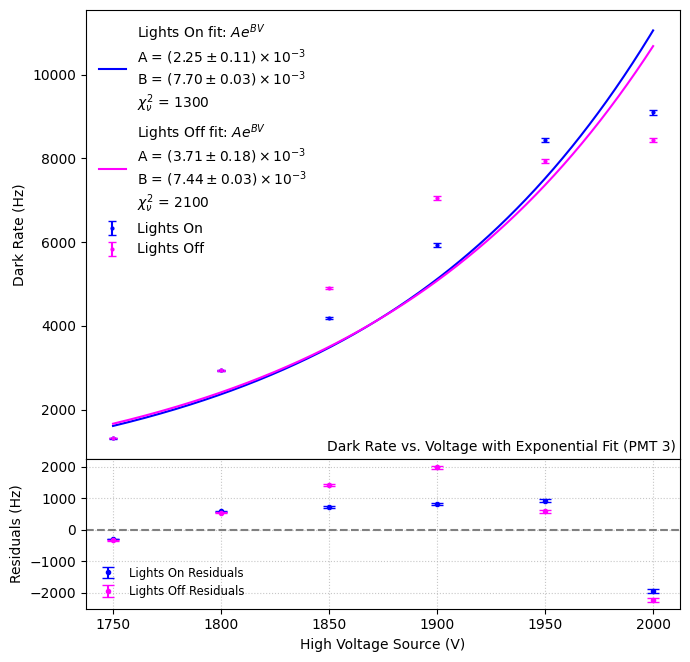


##  Lights On Fit Parameters
A: 2.2519e-03 ± 1.1172e-04
B: 0.0077 ± 0.0000

##  Lights Off Fit Parameters
A: 3.7140e-03 ± 1.8146e-04
B: 0.0074 ± 0.0000

--- Exponential Fit Results: Rate(V) = A * exp(B * V) + C ---

## Lights On Fit Parameters

Chi-Squared ($\chi^2$): 5.056e+03
Degrees of Freedom ($
u$): 4
Reduced Chi-Squared ($\chi^2_
u$): 1.264e+03

## Lights Off Fit Parameters

Chi-Squared ($\chi^2$): 8513.476
Degrees of Freedom ($
u$): 4
Reduced Chi-Squared ($\chi^2_
u$): 2128.369


In [49]:
#15sigma threshold
#plot dark rate against voltage for lights on and lights off on the same plot.

#these will be lists of voltages with their corresponding dark rates. eg. {1750: [213,453,241], 2000: [542,622,315]}
lights_on = {} 
lights_off = {}

for file, (darkrate, DR_err) in dark_rates.items():
    df = pd.read_csv(file)
    #extract voltage, trial number and light on/off from filename
    match = re.search(r"darkrate_(\d+)_10000_(\d+)_(on|off)", file)

    voltage = int(match.group(1))
    trial_number = int(match.group(2))
    light_state = match.group(3)

    #store light state.
    if light_state == 'on':
        lights_on.setdefault(voltage,[]).append((darkrate, DR_err))
    if light_state == 'off':
        lights_off.setdefault(voltage,[]).append((darkrate, DR_err))

#average trials for each voltage
#ADD ERROR ON MEAN AND PUT IN PLOT
for voltage, rate_list in lights_on.items():
    rate, err= zip(*rate_list)
    
    rate = np.array(rate)
    err = np.array(err)

    valid_mask = (err > 0) & np.isfinite(err) & np.isfinite(rate) 
    valid_rate = rate[valid_mask]
    valid_err = err[valid_mask]

    x = len(valid_rate)
    mean_rate = sum(valid_rate)/len(valid_rate)
    mean_err = np.sqrt((1/x)**2 * np.sum((valid_err**2))) # combine in quadrature
    lights_on[voltage] = (mean_rate, mean_err) #replace the list with a single average rate element
    print(mean_rate)
    print(mean_err)

for voltage, rate_list in lights_off.items():
    rate, err= zip(*rate_list)
   
    rate = np.array(rate)
    err = np.array(err)

    valid_mask = (err > 0) & np.isfinite(err) & np.isfinite(rate) 
    valid_rate = rate[valid_mask]
    valid_err = err[valid_mask]

    x = len(valid_rate)
    mean_rate = sum(valid_rate)/len(valid_rate)
    mean_err = np.sqrt((1/x)**2 * np.sum((valid_err**2))) 
    lights_off[voltage] = (mean_rate, mean_err)
    print(mean_rate)

voltages_on = sorted(lights_on.keys())
average_rate_on = [lights_on[v][0] for v in voltages_on]
average_err_on = [lights_on[v][1] for v in voltages_on]
voltages_off = sorted(lights_off.keys())
average_rate_off = [lights_off[v][0] for v in voltages_off]
average_err_off = [lights_off[v][1] for v in voltages_off]

def exponential_C(V, A, B, C):
    return A * np.exp(B * V) + C

def exponential(V, A, B):
    return A * np.exp(B * V)

def linear(V, m, c):
    return m*V + c

voltages_on_np = np.array(voltages_on)
average_rate_on_np = np.array(average_rate_on)
average_err_on_np = np.array(average_err_on)

finite_mask_on = np.isfinite(average_rate_on_np) & np.isfinite(average_err_on_np)

V_fit_on = voltages_on_np[finite_mask_on]
Rate_fit_on = average_rate_on_np[finite_mask_on]
Err_fit_on = average_err_on_np[finite_mask_on]

try:
    popt_on, pcov_on = curve_fit(
        f=exponential,
        xdata=V_fit_on,
        ydata=Rate_fit_on,
        sigma=Err_fit_on,
        absolute_sigma=True,
        p0=[1e-6, 0.01]  # Initial guess for A, B
    )
    rate_fit_on_points = exponential(V_fit_on, *popt_on)
    perr_on = np.sqrt(np.diag(pcov_on))
except RuntimeError:
    print("Lights On curve fit failed.")
    popt_on = None

V_dense_on = np.linspace(np.min(V_fit_on), np.max(V_fit_on), 1000)
Rate_dense_on = exponential(V_dense_on, *popt_on)

voltages_off_np = np.array(voltages_off)
average_rate_off_np = np.array(average_rate_off)
average_err_off_np = np.array(average_err_off)

finite_mask_off = np.isfinite(average_rate_off_np) & np.isfinite(average_err_off_np)

V_fit_off = voltages_off_np[finite_mask_off]
Rate_fit_off = average_rate_off_np[finite_mask_off]
Err_fit_off = average_err_off_np[finite_mask_off]


try:
    popt_off, pcov_off = curve_fit(
        f=exponential,
        xdata=V_fit_off,
        ydata=Rate_fit_off,
        sigma=Err_fit_off,
        absolute_sigma=True,
        p0=[1e-6, 0.01]  # Initial guess for A, B
    )
    rate_fit_off_points = exponential(V_fit_off, *popt_off)
    perr_off = np.sqrt(np.diag(pcov_off))
except RuntimeError:
    print("Lights Off curve fit failed.")
    popt_off = None

V_dense_off = np.linspace(np.min(V_fit_off), np.max(V_fit_off), 1000)
Rate_dense_off = exponential(V_dense_off, *popt_off)

fig, (ax_main, ax_res) = plt.subplots(
    nrows=2, 
    ncols=1, 
    sharex=True, 
    figsize=(7, 7), 
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0} # 3:1 ratio and no vertical space
)



# --- Residuals Calculation and Plotting ---



# 1. Calculate and Plot Lights On Residuals
if popt_on is not None:
    # Residuals = (Measured Rate) - (Fitted Rate at that Voltage)
    residuals_on = Rate_fit_on - rate_fit_on_points
    
    # Optional: Plot standardized residuals (Residuals / Error) if you want to normalize by uncertainty
    # standardized_residuals_on = residuals_on / average_err_on_np
    ax_res.errorbar(
        V_fit_on, 
        residuals_on, 
        yerr=Err_fit_on, 
        ms=3, 
        capsize=4, 
        fmt='o', 
        color='blue', 
        label='Lights On Residuals'
    )

# 2. Calculate and Plot Lights Off Residuals
if popt_off is not None:
    residuals_off = Rate_fit_off - rate_fit_off_points
    
    ax_res.errorbar(
        V_fit_off, 
        residuals_off, 
        yerr=Err_fit_off, 
        ms=3, 
        capsize=4, 
        fmt='o', 
        color='magenta', 
        label='Lights Off Residuals'
    )

# ---- Chi-squared: Lights ON ----
chi2_on = None
chi2nu_on = None

if popt_on is not None:
    non_zero = Err_fit_on > 0
    chi2_on = np.sum((residuals_on[non_zero] / Err_fit_on[non_zero])**2)
    nu_on = len(Rate_fit_on[non_zero]) - len(popt_on)
    chi2nu_on = chi2_on / nu_on


# ---- Chi-squared: Lights OFF ----
chi2_off = None
chi2nu_off = None

if popt_off is not None:
    non_zero = Err_fit_off > 0
    chi2_off = np.sum((residuals_off[non_zero] / Err_fit_off[non_zero])**2)
    nu_off = len(Rate_fit_off[non_zero]) - len(popt_off)
    chi2nu_off = chi2_off / nu_off

# corect decimal places
def fmt_sig_figs(val, n=2):
    """Rounds a number to n significant figures and returns as a string."""
    if val == 0:
        return "0"
    # Calculate the order of magnitude
    mag = floor(log10(abs(val)))
    # Round to the appropriate decimal place
    rounded_val = round(val, -int(mag - (n - 1)))
    # Format as a float to avoid scientific notation in the string
    return f"{rounded_val:g}"
'''
# ---- Lights ON fit ----
if popt_on is not None:
    # Rounding both value and error to 2 significant figures
    a_val = fmt_sig_figs(popt_on[0], n=3)
    a_err = fmt_sig_figs(perr_on[0], n=2)
    
    b_val = fmt_sig_figs(popt_on[1], n=3)
    b_err = fmt_sig_figs(perr_on[1], n=1)
    
    label_on = (
        r'Lights On fit: $A e^{BV}$' +
        f'\nA={a_val}±{a_err}, '
        f'B={b_val}±{b_err}'
    )
    
    if chi2nu_on is not None:
        label_on += f'\n$\chi^2_\\nu$ = {fmt_sig_figs(chi2nu_on, n=2)}'

# ---- Lights OFF fit ----
if popt_off is not None:
    a_val_off = fmt_sig_figs(popt_off[0], n=3)
    a_err_off = fmt_sig_figs(perr_off[0], n=2)
    
    b_val_off = fmt_sig_figs(popt_off[1], n=3)
    b_err_off = fmt_sig_figs(perr_off[1], n=1)
    
    label_off = (
        r'Lights Off fit: $A e^{BV}$' +
        f'\nA={a_val_off}±{a_err_off}, '
        f'B={b_val_off}±{b_err_off}'
    )
    
    if chi2nu_off is not None:
        label_off += f'\n$\chi^2_\\nu$ = {fmt_sig_figs(chi2nu_off, n=2)}'

'''
def format_scientific_latex(val, err, n=2):
    """
    Formats a value and error into LaTeX scientific notation 
    sharing the same power of 10.
    """
    if err <= 0:
        return f"{val:.1e} \pm {err:.1e}"

    # 1. Find the exponent of the value
    exponent = floor(log10(abs(val)))
    
    # 2. Scale both by that exponent
    factor = 10**exponent
    scaled_val = val / factor
    scaled_err = err / factor
    
    # 3. Return the LaTeX string
    # n controls decimal places (e.g., n=2 gives 1.23)
    return (f"({scaled_val:.{n}f} \pm {scaled_err:.{n}f}) "
            f"\\times 10^{{{exponent}}}")

# ---- Lights ON fit ----
if popt_on is not None:
    a_tex_on = format_scientific_latex(popt_on[0], perr_on[0], n=2)
    b_tex_on = format_scientific_latex(popt_on[1], perr_on[1], n=2)
    
    label_on = (
        r'Lights On fit: $A e^{BV}$' +
        f'\nA = ${a_tex_on}$' +
        f'\nB = ${b_tex_on}$'
    )
    if chi2nu_on is not None:
        label_on += f'\n$\chi^2_\\nu$ = {fmt_sig_figs(chi2nu_on, n=2)}'

# ---- Lights OFF fit ----
if popt_off is not None:
    a_tex_off = format_scientific_latex(popt_off[0], perr_off[0], n=2)
    b_tex_off = format_scientific_latex(popt_off[1], perr_off[1], n=2)
    
    label_off = (
        r'Lights Off fit: $A e^{BV}$' +
        f'\nA = ${a_tex_off}$' +
        f'\nB = ${b_tex_off}$'
    )
    if chi2nu_off is not None:
        label_off += f'\n$\chi^2_\\nu$ = {fmt_sig_figs(chi2nu_off, n=2)}'

'''
# ---- Lights ON fit ----
if popt_on is not None:
    label_on = (
        r'Lights On fit: $A e^{BV}$' +
        f'\nA={popt_on[0]:.2e}±{perr_on[0]:.1e}, '
        f'B={popt_on[1]:.2e}±{perr_on[1]:.1e}'
    )
    
    if chi2nu_on is not None:
        label_on += f'\n$\chi^2_\\nu$ = {chi2nu_on:.2g}'



# ---- Lights OFF fit ----
if popt_off is not None:
    label_off = (
        r'Lights Off fit: $A e^{BV}$' +
        f'\nA={popt_off[0]:.2e}±{perr_off[0]:.1e}, '
        f'B={popt_off[1]:.2e}±{perr_off[1]:.1e}'
    )
    
    if chi2nu_off is not None:
        label_off += f'\n$\chi^2_\\nu$ = {chi2nu_off:.2g}'

'''

ax_main.errorbar(voltages_on, average_rate_on, yerr = average_err_on, ms=2, capsize=3, fmt='o', color='blue', label = 'Lights On')
ax_main.errorbar(voltages_off, average_rate_off, yerr=average_err_off, ms=2, capsize=3, fmt='o', color='magenta', label = 'Lights Off')
if popt_on is not None:
    #ax_main.plot(V_dense_on, Rate_dense_on, 'b-', label=(r'Rate = $A \cdot e^{B \cdot V}$' + f':  A = {popt_on[0]:.4e} ± {perr_on[0]:.4e} , B = {popt_on[1]:.4e} ± {perr_on[1]:.4e}'))
    ax_main.plot(V_dense_on, Rate_dense_on, 'b-', label=label_on)
# Plot the 'Lights Off' fit line, connecting the fitted points
if popt_off is not None:
    #ax_main.plot(V_dense_off, Rate_dense_off, color='magenta', linestyle='-', label=(r'Rate = $A \cdot e^{B \cdot V}$' + f': A = {popt_off[0]:.4e} ± {perr_off[0]:.4e} , B = {popt_off[1]:.4e} ± {perr_off[1]:.4e}'))
    ax_main.plot(V_dense_off, Rate_dense_off, color='magenta', linestyle='-', label=label_off)
plt.xlabel('High Voltage Source (V)')
ax_main.set_ylabel('Dark Rate (Hz)')
plt.title('Dark Rate vs. Voltage with Exponential Fit (PMT 3) ', loc='right', fontsize='medium')
ax_main.legend(loc='upper left', fontsize='medium', frameon=False)
# Remove the x-axis tick labels for the main plot since the x-axis is shared

ax_res.axhline(0, color='gray', linestyle='--') # Draw a horizontal line at y=0
ax_main.tick_params(axis='x', labelbottom=False)
ax_res.set_xlabel('High Voltage Source (V)')
ax_res.set_ylabel('Residuals (Hz)')
ax_res.grid(True, linestyle=':', alpha=0.7)
ax_res.legend(loc='lower left', fontsize='small', frameon=False)



# 3. Final Display
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

if popt_on is not None:
    print("\n##  Lights On Fit Parameters")
    print(f"A: {popt_on[0]:.4e} ± {perr_on[0]:.4e}")
    print(f"B: {popt_on[1]:.4f} ± {perr_on[1]:.4f}")
    #print(f"C: {popt_on[2]:.2f} ± {perr_on[2]:.2f} Hz")
    
if popt_off is not None:
    print("\n##  Lights Off Fit Parameters")
    print(f"A: {popt_off[0]:.4e} ± {perr_off[0]:.4e}")
    print(f"B: {popt_off[1]:.4f} ± {perr_off[1]:.4f}")
    #print(f"C: {popt_off[2]:.2f} ± {perr_off[2]:.2f} Hz")

    print("\n--- Exponential Fit Results: Rate(V) = A * exp(B * V) + C ---")

chi2_on = None
if popt_on is not None:
    # Calculate the chi-squared statistic for Lights On
    # Residuals = average_rate_on_np - rate_fit_on_points (calculated in previous step)
    # The error is average_err_on_np
    
    # Check for zero errors to avoid division by zero
    non_zero_errors_on = Err_fit_on > 0
    if np.any(non_zero_errors_on):
        chi2_on = np.sum(
            (residuals_on[non_zero_errors_on] / Err_fit_on[non_zero_errors_on])**2
        )
    else:
        print("Cannot calculate Chi-squared for Lights On: all errors are zero.")

#chi2_off = None
#if popt_off is not None:
    # Calculate the chi-squared statistic for Lights Off
    # Residuals = average_rate_off_np - rate_fit_off_points
    # The error is average_err_off_np
    
    non_zero_errors_off = Err_fit_off > 0
    if np.any(non_zero_errors_off):
        chi2_off = np.sum(
            (residuals_off[non_zero_errors_off] / Err_fit_off[non_zero_errors_off])**2
        )
    else:
        print("Cannot calculate Chi-squared for Lights Off: all errors are zero.")

if popt_on is not None:
    N_on = len(V_fit_on)
    P = len(popt_on)
    nu_on = N_on - P
    
    print("\n## Lights On Fit Parameters")
    # ... (Your existing A, B, C prints) ...
    
    if chi2_on is not None and nu_on > 0:
        chi2_nu_on = chi2_on / nu_on
        print(f"\nChi-Squared ($\chi^2$): {chi2_on:.3e}")
        print(f"Degrees of Freedom ($\nu$): {nu_on}")
        print(f"Reduced Chi-Squared ($\chi^2_\nu$): {chi2_nu_on:.3e}")
    
if popt_off is not None:
    N_off = len(V_fit_off)
    P = len(popt_off)
    nu_off = N_off - P

    print("\n## Lights Off Fit Parameters")
    # ... (Your existing A, B, C prints) ...
    
    if chi2_off is not None and nu_off > 0:
        chi2_nu_off = chi2_off / nu_off
        print(f"\nChi-Squared ($\chi^2$): {chi2_off:.3f}")
        print(f"Degrees of Freedom ($\nu$): {nu_off}")
        print(f"Reduced Chi-Squared ($\chi^2_\nu$): {chi2_nu_off:.3f}")

